SWAE model for generating 129*129 bmps in Verti-Bench

In [2]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torch.autograd import Variable
from torch import distributions as dist

In [3]:
#For one dataset
class BMPLoader(Dataset):
    def __init__(self, base_directory):
        self.base_directory = base_directory
        self.file_names = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if f.endswith('.bmp')]
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0, 1] range
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
        ])
    
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_names[idx])
        img = img.convert('L')  # Convert to grayscale
        return self.transform(img)

In [ ]:
# # Data for ACL
# dataset = BMPLoader('../data/Automatic-CL/TrainSet-train')
# # # Data for MCL
# # dataset = BMPLoader('../data/Manual-CL/TrainSet')
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# # Print the number of images in the dataset
# print(f"Number of images in the dataset: {len(dataset)}")

# # #Test for subset
# # subset_indices = random.sample(range(len(dataset)), 1000)
# # subset_dataset = Subset(dataset, subset_indices)
# # dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

In [ ]:
# Data for Benchmark
dataset = BMPLoader('../data/BenchMaps/elev_maps')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Print the number of images in the dataset
print(f"Number of images in the dataset: {len(dataset)}")

Number of images in the dataset: 1000


In [6]:
from torch import nn
from abc import abstractmethod
from typing import Callable, List, Any, Optional, Sequence, Type

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [7]:
class SWAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 reg_weight: int = 100,
                 wasserstein_deg: float= 2.,
                 num_projections: int = 200,
                 projection_dist: str = 'normal',
                    **kwargs) -> None:
        super(SWAE, self).__init__()

        self.latent_dim = latent_dim
        self.reg_weight = reg_weight
        self.p = wasserstein_deg
        self.num_projections = num_projections
        self.proj_dist = projection_dist

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_z = nn.Linear(hidden_dims[-1]*4*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4*4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> Tensor:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        z = self.fc_z(result)
        return z

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2*2, 2*2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        z = self.encode(input)
        return  [self.decode(z), input, z]

    def loss_function(self, recons, input, z) -> dict:
        batch_size = input.size(0)
        bias_corr = batch_size *  (batch_size - 1)
        reg_weight = self.reg_weight / bias_corr

        recons_loss_l2 = F.mse_loss(recons, input)
        recons_loss_l1 = F.l1_loss(recons, input)

        swd_loss = self.compute_swd(z, self.p, reg_weight)

        loss = recons_loss_l2 + recons_loss_l1 + swd_loss
        return loss

    def get_random_projections(self, latent_dim: int, num_samples: int) -> Tensor:
        """
        Returns random samples from latent distribution's (Gaussian)
        unit sphere for projecting the encoded samples and the
        distribution samples.

        :param latent_dim: (Int) Dimensionality of the latent space (D)
        :param num_samples: (Int) Number of samples required (S)
        :return: Random projections from the latent unit sphere
        """
        if self.proj_dist == 'normal':
            rand_samples = torch.randn(num_samples, latent_dim)
        elif self.proj_dist == 'cauchy':
            rand_samples = dist.Cauchy(torch.tensor([0.0]),
                                       torch.tensor([1.0])).sample((num_samples, latent_dim)).squeeze()
        else:
            raise ValueError('Unknown projection distribution.')

        rand_proj = rand_samples / rand_samples.norm(dim=1).view(-1,1)
        return rand_proj # [S x D]


    def compute_swd(self,
                    z: Tensor,
                    p: float,
                    reg_weight: float) -> Tensor:
        """
        Computes the Sliced Wasserstein Distance (SWD) - which consists of
        randomly projecting the encoded and prior vectors and computing
        their Wasserstein distance along those projections.

        :param z: Latent samples # [N  x D]
        :param p: Value for the p^th Wasserstein distance
        :param reg_weight:
        :return:
        """
        prior_z = torch.randn_like(z) # [N x D]
        device = z.device

        proj_matrix = self.get_random_projections(self.latent_dim,
                                                  num_samples=self.num_projections).transpose(0,1).to(device)

        latent_projections = z.matmul(proj_matrix) # [N x S]
        prior_projections = prior_z.matmul(proj_matrix) # [N x S]

        # The Wasserstein distance is computed by sorting the two projections
        # across the batches and computing their element-wise l2 distance
        w_dist = torch.sort(latent_projections.t(), dim=1)[0] - \
                 torch.sort(prior_projections.t(), dim=1)[0]
        w_dist = w_dist.pow(p)
        return reg_weight * w_dist.mean()
    
    def freeze_encoder(self):
        for param in list(self.encoder.parameters()) + list(self.fc_z.parameters()):
            param.requires_grad = False

In [8]:
# # Test which dimension is better
# latent_dims = [8, 16, 32, 64, 128, 256, 512, 1024]  # Example latent dimensions to test
# num_epochs = 100
# learning_rate = 5e-3
# loss_values_per_dim = {}

# for latent_dim in latent_dims:
#     model = SWAE(in_channels=1, latent_dim=latent_dim)
    
#     print(torch.cuda.is_available())
#     if torch.cuda.is_available():
#         model.cuda()

#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     loss_values = []
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         num_batches = 0
#         for batch_idx, img in enumerate(dataloader):
#             img = img.to(device)
#             optimizer.zero_grad()
#             recon_batch, input, z = model(img)
#             loss = model.loss_function(recon_batch, input, z)
#             loss.backward()
#             train_loss += loss.item()
#             optimizer.step()
#             num_batches += 1
        
#         average_loss = train_loss / num_batches
#         loss_values.append(average_loss)
#         print(f'Latent Dim: {latent_dim}, Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

#     loss_values_per_dim[latent_dim] = loss_values

In [9]:
# # Plotting the results
# for latent_dim, losses in loss_values_per_dim.items():
#     plt.plot(losses, label=f'Latent Dim: {latent_dim}')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.legend()
# plt.show()

In [10]:
# mean_losses_per_dim = {latent_dim: np.mean(losses) for latent_dim, losses in loss_values_per_dim.items()}
# print(mean_losses_per_dim)
# min_dim, min_loss = min(mean_losses_per_dim.items(), key=lambda x: x[1])
# print(min_dim, min_loss)

In [11]:
model = SWAE(in_channels=1, latent_dim=64)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    model.cuda()

True


In [ ]:
# # When not training, comment the following line
# num_epochs = 500
# learning_rate = 5e-3

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loss_values = []
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     num_batches = 0
#     for batch_idx, img in enumerate(dataloader):
#         img = img.to(device)
#         optimizer.zero_grad()
#         recon_batch, input, z = model(img)
#         loss = model.loss_function(recon_batch, input, z) 
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#         num_batches += 1
    
#     average_loss = train_loss / num_batches
#     loss_values.append(average_loss)  # Append the average loss over batches
#     print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

Epoch [1/500], Average Loss: 0.7775
Epoch [2/500], Average Loss: 0.2755
Epoch [3/500], Average Loss: 0.1704
Epoch [4/500], Average Loss: 0.1435
Epoch [5/500], Average Loss: 0.1355
Epoch [6/500], Average Loss: 0.1330
Epoch [7/500], Average Loss: 0.1337
Epoch [8/500], Average Loss: 0.1268
Epoch [9/500], Average Loss: 0.1244
Epoch [10/500], Average Loss: 0.1217
Epoch [11/500], Average Loss: 0.1200
Epoch [12/500], Average Loss: 0.1205
Epoch [13/500], Average Loss: 0.1200
Epoch [14/500], Average Loss: 0.1207
Epoch [15/500], Average Loss: 0.1115
Epoch [16/500], Average Loss: 0.1106
Epoch [17/500], Average Loss: 0.1064
Epoch [18/500], Average Loss: 0.1036
Epoch [19/500], Average Loss: 0.1030
Epoch [20/500], Average Loss: 0.1020
Epoch [21/500], Average Loss: 0.1015
Epoch [22/500], Average Loss: 0.1004
Epoch [23/500], Average Loss: 0.1005
Epoch [24/500], Average Loss: 0.1057
Epoch [25/500], Average Loss: 0.1016
Epoch [26/500], Average Loss: 0.1000
Epoch [27/500], Average Loss: 0.1046
Epoch [28/

In [ ]:
# # When not training, comment the following line
# model.freeze_encoder()
# print("Encoder layers have been frozen.")
# # # Save for ACL
# # torch.save(model.state_dict(), './SWAE_ACL64.pth')
# # # Save for MCL
# # torch.save(model.state_dict(), './SWAE_64.pth')
# # Save for Benchmark
# torch.save(model.state_dict(), './BenchGen.pth')

Encoder layers have been frozen.


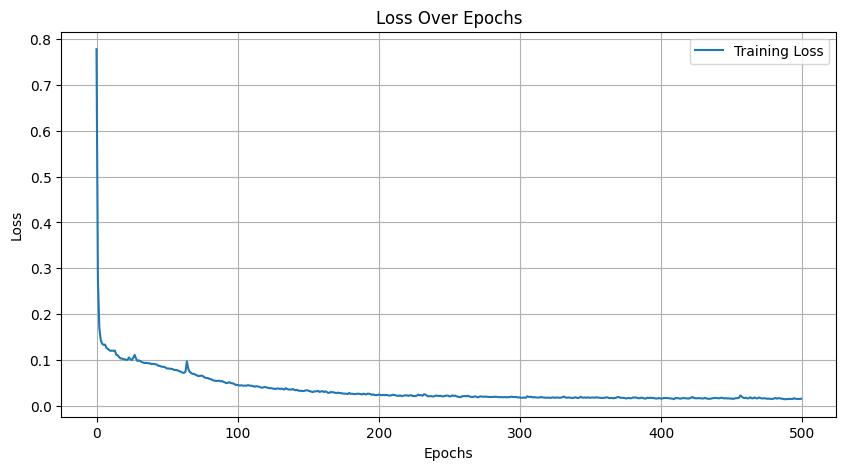

In [ ]:
# # When not training, comment the following line
# plt.figure(figsize=(10, 5))
# plt.plot(loss_values, label='Training Loss')
# plt.title('Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# # Data for ACL
# Trainset = BMPLoader('../data/Automatic-CL/TrainSet-train')
# Testset = BMPLoader('../data/Automatic-CL/TrainSet-test')

# # Data for MCL
# Trainset = BMPLoader('../data/Manual-CL/TrainSet')
# Testset = BMPLoader('../data/Manual-CL/TestSet')

# Data for Benchmark
Trainset = BMPLoader('../data/BenchMaps/elev_maps')

Visualizing reconstructions of training images...


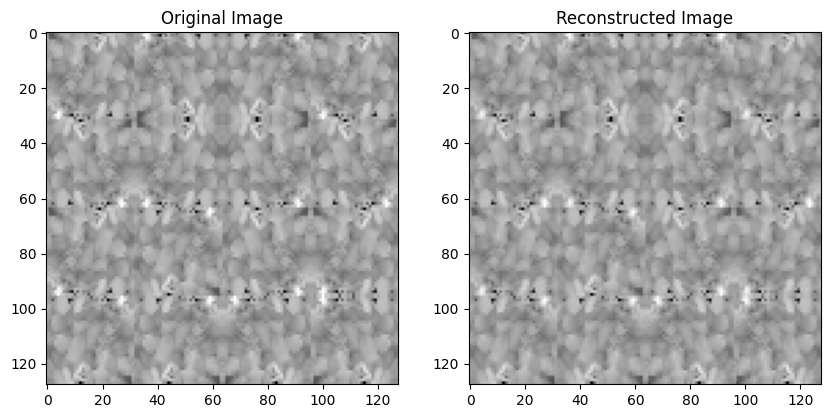

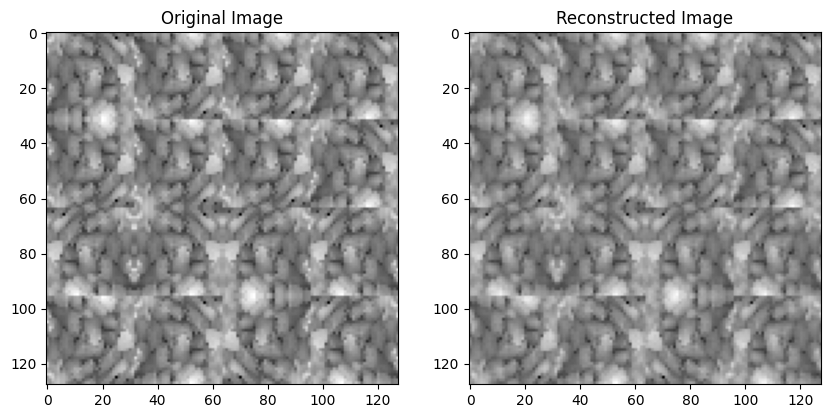

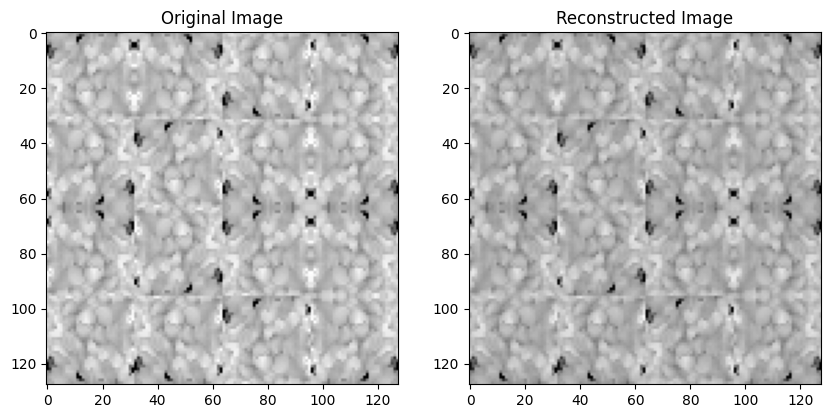

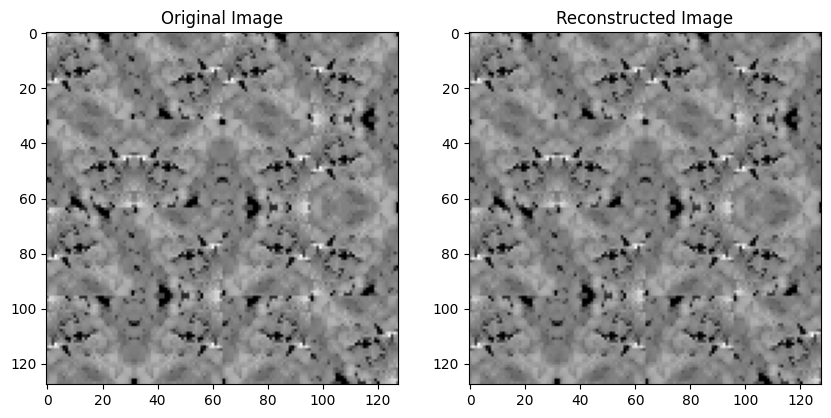

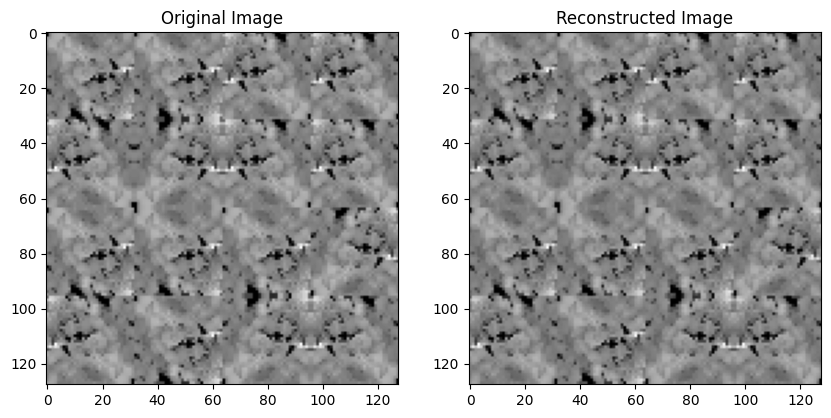

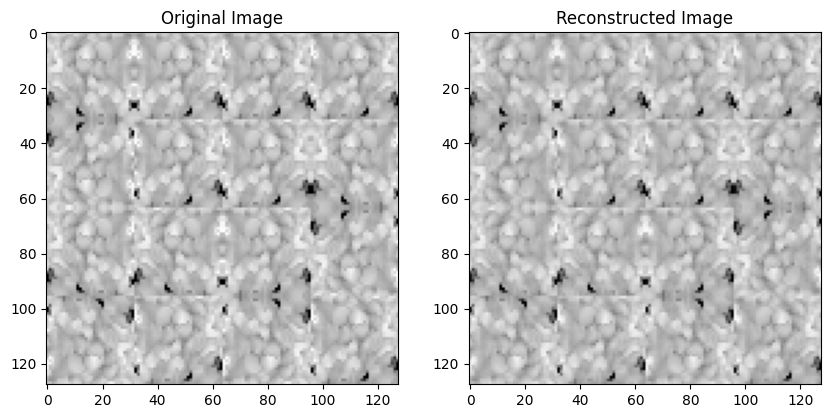

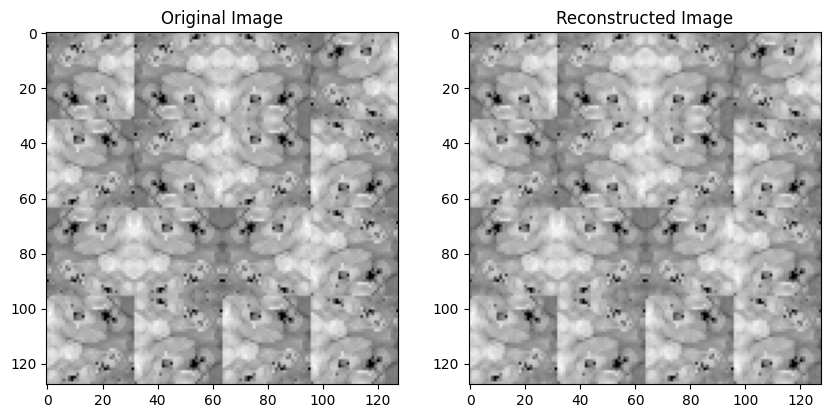

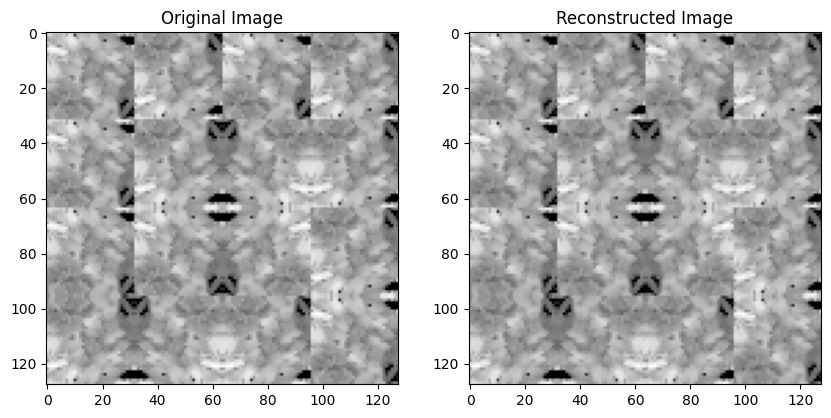

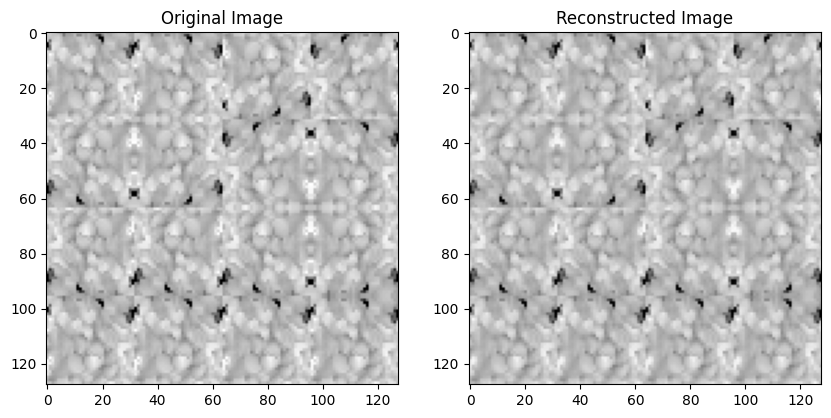

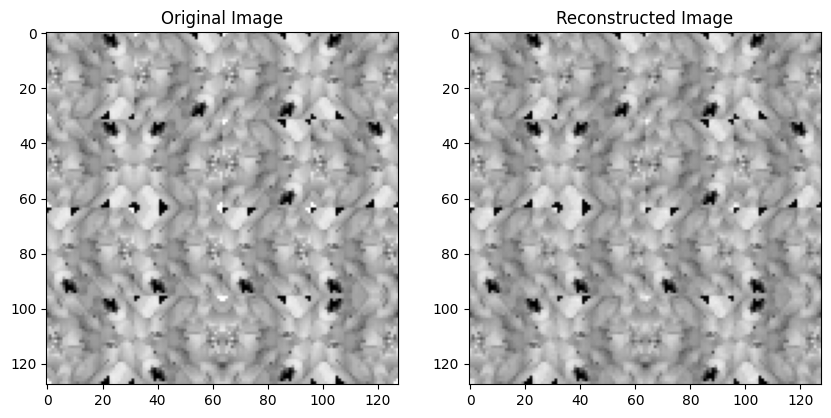

In [12]:
# View the reconstructions of training images
import random
import matplotlib.pyplot as plt

# Function to convert tensor to image for visualization
def to_img(x):
    x = x.clamp(-1, 1) # Clamp values to [-1, 1]
    x = x.view(-1, 128, 128)
    return x

# Function to display original and reconstructed images
def display_images(original, reconstructed):
    original_img = to_img(original.cpu())
    reconstructed_img = to_img(reconstructed.cpu())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img[0].numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img[0].numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Main loop to process and display images from the train set
def visualize_reconstructions(model, trainset, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load('./Bench_128.pth', map_location=device, weights_only=True))
    model.eval()
    model.to(device)
    
    # Randomly pick indices for images
    indices = random.sample(range(len(trainset)), num_images)
    
    # Loop through the randomly selected indices
    for idx in indices:
        img = trainset[idx].unsqueeze(0).to(device)
        
        # Get reconstruction
        with torch.no_grad():
            reconstructed_image, input, latentVector = model(img)
        
        # Display images
        display_images(img, reconstructed_image)

# Assuming 'Trainset' is your train dataset
print("Visualizing reconstructions of training images...")
visualize_reconstructions(model, Trainset)

In [13]:
# # View the reconstructions of test images
# import random
# import matplotlib.pyplot as plt

# # Function to convert tensor to image for visualization
# def to_img(x):
#     x = x.clamp(-1, 1)
#     x = x.view(-1, 64, 64)
#     return x

# # Function to display original and reconstructed images
# def display_images(original, reconstructed):
#     original_img = to_img(original.cpu())
#     reconstructed_img = to_img(reconstructed.cpu())
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(original_img[0].numpy(), cmap='gray')
#     plt.title('Original Image')
#     plt.subplot(1, 2, 2)
#     plt.imshow(reconstructed_img[0].numpy(), cmap='gray')
#     plt.title('Reconstructed Image')
#     plt.show()

# # Main loop to process and display images from the test set
# def visualize_reconstructions(model, testset, num_images=10):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.load_state_dict(torch.load('./SWAE_64.pth'))
#     model.eval()
#     model.to(device)
    
#     # Randomly pick indices for images
#     indices = random.sample(range(len(testset)), num_images)
    
#     # Loop through the randomly selected indices
#     for idx in indices:
#         img = testset[idx].unsqueeze(0).to(device)
        
#         # Get reconstruction
#         with torch.no_grad():
#             reconstructed_image, input, latentVector = model(img)
        
#         # Display images
#         display_images(img, reconstructed_image)

# # Assuming 'Testset' is your test dataset
# print("Visualizing reconstructions of test images...")
# visualize_reconstructions(model, Testset)

In [11]:
model.load_state_dict(torch.load('./BenchGen.pth', weights_only=True))
model.freeze_encoder()
model.eval()

for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

encoder.0.0.weight: requires_grad = False
encoder.0.0.bias: requires_grad = False
encoder.0.1.weight: requires_grad = False
encoder.0.1.bias: requires_grad = False
encoder.1.0.weight: requires_grad = False
encoder.1.0.bias: requires_grad = False
encoder.1.1.weight: requires_grad = False
encoder.1.1.bias: requires_grad = False
encoder.2.0.weight: requires_grad = False
encoder.2.0.bias: requires_grad = False
encoder.2.1.weight: requires_grad = False
encoder.2.1.bias: requires_grad = False
encoder.3.0.weight: requires_grad = False
encoder.3.0.bias: requires_grad = False
encoder.3.1.weight: requires_grad = False
encoder.3.1.bias: requires_grad = False
encoder.4.0.weight: requires_grad = False
encoder.4.0.bias: requires_grad = False
encoder.4.1.weight: requires_grad = False
encoder.4.1.bias: requires_grad = False
fc_z.weight: requires_grad = False
fc_z.bias: requires_grad = False
decoder_input.weight: requires_grad = True
decoder_input.bias: requires_grad = True
decoder.0.0.weight: requires

Sample latent space and use decoder to generate new elevation images

In [ ]:
import os
from PIL import Image, ImageFilter
import torch
import matplotlib.pyplot as plt

# Function to sample latent vectors, generate images, resize them, and save
def sample_generate_and_save_images(model, output_dir='../data/BenchMaps/sampled_maps/worlds', num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the trained model and set it to evaluation mode
    model.load_state_dict(torch.load('./BenchGen.pth', map_location=device, weights_only=True))
    model.eval()
    model.to(device)
    
    # Generate random latent vectors from Gaussian distribution (mean=0, std=1)
    latent_dim = model.latent_dim 
    random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)  # Sample from Gaussian distribution

    # Use the decoder part of the model to generate images from the sampled latent vectors
    with torch.no_grad():
        generated_images = model.decode(random_latent_vectors)

    # Convert the generated images to a format suitable for visualization and saving
    generated_images = generated_images.cpu().detach()

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Function to convert tensor to image for saving
    def to_img(x):
        x = x.clamp(-1, 1)  # Clamp values to [-1, 1] to match image normalization
        x = (x + 1) / 2  # Scale values to [0, 1]
        x = x * 255  # Scale to [0, 255] for saving as an image
        x = x.view(128, 128).numpy().astype(np.uint8)  # Convert to numpy uint8 array
        return x

    # Loop through the generated images, resize them, and save
    for i in range(1, num_samples):
        # Convert to image
        img_array = to_img(generated_images[i])

        # Convert numpy array to PIL Image
        img = Image.fromarray(img_array)
        img = img.resize((129, 129))

        # Save the resized image as a .bmp file with a unique name
        output_path = os.path.join(output_dir, f'{i + 1}.bmp')
        img.save(output_path)

        print(f"Saved image {i + 1} as {output_path}")

# Example usage:
print("Generating, resizing, and saving new images...")
sample_generate_and_save_images(model, num_samples=100)